In [1]:
import os
import math
import random
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import librosa
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
NUM_LABELS = 10

def genOneHot(indexToBeOne):
    global NUM_LABELS
    oneHot = []
    for i in range(NUM_LABELS):
        if i == indexToBeOne:
            oneHot.append(1)
        else:
            oneHot.append(0)
    return np.array(oneHot)

def extractFeatures(raw, sr):
    mfccs = librosa.feature.mfcc(raw, sr=sr, n_mfcc=40)
    return mfccs
    
def loadSoundFiles(filePath, index):
    IDEAL_SIZE = 22050
    NUM_SAMPLES = 1200
    oneHots = []
    soundFiles = os.listdir(filePath)
    features = np.empty((0, 40, 44))
    
    counter = 0
    for soundFile in soundFiles:
        raw, sr = librosa.load(filePath + soundFile)
        if len(raw) == IDEAL_SIZE:
            mfccs = extractFeatures(raw, sr)
            internalFeatures = np.hstack([mfccs])
            internalFeatures = internalFeatures.reshape(1, 40, 44)
            features = np.vstack([features, internalFeatures])
            counter += 1
            
            oneHot = genOneHot(index)
            if len(oneHots) == 0:
                oneHots = oneHot
            else:
                oneHots = np.vstack((oneHots, oneHot))
        
            if (counter % (NUM_SAMPLES / 10)) == 0:
                print(str((counter/NUM_SAMPLES) * 100) + "% complete")
        
            if counter == NUM_SAMPLES:
                break
            
    print("The one hot signature for this word is: " + str(oneHots[0]))
    print("The number of samples for this word is: " + str(len(features)))
        
    return np.array(features), oneHots
    
data = []
oneHots = []
rootDir = "./train/audio/"
acceptedWords = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
count = 1
for acceptedWord in acceptedWords:
    print(str(count) + "/" + str(NUM_LABELS))
    features, oneHot = loadSoundFiles(rootDir + acceptedWord + "/", count-1)
    data.append(features)
    oneHots.append(oneHot)
    count += 1
    
print("DONE")

1/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [1 0 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
2/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 1 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
3/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 1 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
4/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 0 1 0 0 0 

In [14]:
dataTraining = []
trainingLabels = []
dataTest = []
testLabels = []

minSamples = 1000000
for training in data:
    if minSamples > len(training):
        minSamples = len(training)

numTrainingSamples = int(minSamples * 0.8)
numTestSamples = int(minSamples * 0.2)

for datasubset in data:
    if len(dataTraining) == 0:
        dataTraining = datasubset[:numTrainingSamples]
        dataTest = datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        dataTraining = np.vstack((dataTraining, datasubset[:numTrainingSamples]))
        dataTest = np.vstack((dataTest, datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]))
               
for oneHotInfo in oneHots:
    if len(trainingLabels) == 0:
        trainingLabels = oneHotInfo[:numTrainingSamples]
        testLabels = oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        trainingLabels = np.vstack((trainingLabels, oneHotInfo[:numTrainingSamples]))
        testLabels = np.vstack((testLabels, oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]))

print("Finished formatting the data to remove bias and to be ready for training")

Finished formatting the data to remove bias and to be ready for training


In [15]:
dataTraining, trainingLabels = shuffle(dataTraining, trainingLabels)
dataTest, testLabels = shuffle(dataTest, testLabels)
print("Randomized the order of the data and labels keeping the relationship 1 to 1")

Randomized the order of the data and labels keeping the relationship 1 to 1


In [26]:
def getBatch(data, labels, batchSize):
    randomIndexes = np.random.choice(len(data), batchSize)
    return data[randomIndexes], labels[randomIndexes]

In [58]:
tf.reset_default_graph()

NUM_CLASSIFICATIONS = NUM_LABELS
DENSE_LAYER = 1024
RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 1000
ITERATIONS_PER_EPOCH = 50

x = tf.placeholder(tf.float32, (None, 1760))
ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
logits1 = tf.layers.dense(inputs=x, units=DENSE_LAYER, activation=tf.nn.relu, name="L1")
logits2 = tf.layers.dense(inputs=logits1, units=NUM_CLASSIFICATIONS, activation=None, name="L2")
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits2, labels=ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(cost)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    inputData = inputData.reshape(-1, 40*44)
    crossData, crossAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    crossData = crossData.reshape(-1, 40*44)
    for _ in range(ITERATIONS_PER_EPOCH):
        s.run((optimizer), feed_dict={x: inputData, ref: correctAns})
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            err = s.run((cost), feed_dict={x: inputData, ref: correctAns})
            crossErr = s.run((cost), feed_dict={x: crossData, ref: crossAns})
            trainingErrors.append(err)
            crossErrors.append(crossErr)
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 1.12759. Cross Validation Error = 2.40393
2% complete: Training Error = 1.66688. Cross Validation Error = 2.63782
3% complete: Training Error = 1.15851. Cross Validation Error = 1.83997
4% complete: Training Error = 0.92565. Cross Validation Error = 2.1782
5% complete: Training Error = 0.896615. Cross Validation Error = 1.9686
6% complete: Training Error = 0.749329. Cross Validation Error = 1.88843
7% complete: Training Error = 0.729125. Cross Validation Error = 1.85105
8% complete: Training Error = 0.571973. Cross Validation Error = 2.21583
9% complete: Training Error = 0.41715. Cross Validation Error = 2.05753
10% complete: Training Error = 0.534512. Cross Validation Error = 2.28852
11% complete: Training Error = 0.452529. Cross Validation Error = 1.67872
12% complete: Training Error = 0.252463. Cross Validation Error = 1.90611
13% complete: Training Error = 0.305329. Cross Validation Error = 2.02172
14% complete: Training Error = 0.116687. Cross Validat

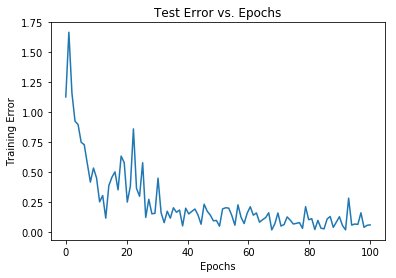

In [59]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

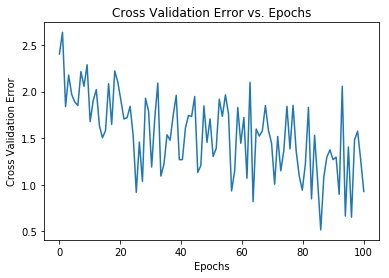

In [60]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [61]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTraining.reshape(-1, 1760)})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for trainingLabel in trainingLabels:
    if (np.argmax(trainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(trainingLabel)] += 1
    count += 1

print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The mlp neural network is 74.9375% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 83.85416667  48.95833333  75.          72.60416667  62.29166667
  84.47916667  74.47916667  79.16666667  90.41666667  78.125     ]


In [62]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTest.reshape(-1, 1760)})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for testLabel in testLabels:
    if (np.argmax(testLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(testLabel)] += 1
    count += 1
    
print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The mlp neural network is 67.5% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 82.08333333  38.75        64.58333333  62.08333333  54.16666667
  78.33333333  67.5         72.08333333  89.58333333  65.83333333]


In [63]:
cnnTraining = dataTraining
cnnTrainingLabels = trainingLabels
cnnTest = dataTest
cnnTestLabels = testLabels

def fixShape(data):
    return data.reshape(-1, 1, 1760, 1)

In [64]:
tf.reset_default_graph()

DENSE_LAYER = 1024
NUM_CLASSIFICATIONS = NUM_LABELS
RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 1000
ITERATIONS_PER_EPOCH = 50
DROP_OUT_RATE = 0.5

class N():
    pass

model = N()

model.x = tf.placeholder(tf.float32, (None, 1, None, 1))
model.ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
model.drop = tf.placeholder(tf.float32)
model.L1 = tf.layers.conv2d(model.x, filters=32, kernel_size=(1,22), padding="SAME", activation=tf.nn.relu)
model.L2 = tf.layers.max_pooling2d(inputs=model.L1, pool_size=(1,11), strides=(1, 11))
model.L3 = tf.layers.conv2d(model.L2, filters=64, kernel_size=(1,8), padding="SAME", activation=tf.nn.relu)
model.L4 = tf.layers.max_pooling2d(inputs=model.L3, pool_size=(1,4), strides=(1, 4))
model.L5 = tf.reshape(model.L4, (-1, 40*64))
model.L6 = tf.layers.dense(inputs=model.L5, units=DENSE_LAYER, activation=tf.nn.relu)
model.L7 = tf.nn.dropout(model.L6, model.drop)
model.L8 = tf.layers.dense(inputs=model.L7, units=NUM_CLASSIFICATIONS)
model.err = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.L8, labels=model.ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(model.err)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    inputData = fixShape(inputData)
    crossData, crossAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    crossData = fixShape(crossData)
    for _ in range(ITERATIONS_PER_EPOCH):
        s.run((optimizer), feed_dict={model.x: inputData, model.ref: correctAns, model.drop: DROP_OUT_RATE})
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            err = s.run((model.err), feed_dict={model.x: inputData, model.ref: correctAns, model.drop: DROP_OUT_RATE})
            crossErr = s.run((model.err), feed_dict={model.x: crossData, model.ref: crossAns, model.drop: DROP_OUT_RATE})
            trainingErrors.append(err)
            crossErrors.append(crossErr)
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 0.894875. Cross Validation Error = 1.79144
2% complete: Training Error = 0.428158. Cross Validation Error = 1.49889
3% complete: Training Error = 0.29017. Cross Validation Error = 1.22391
4% complete: Training Error = 0.263272. Cross Validation Error = 1.16217
5% complete: Training Error = 0.136925. Cross Validation Error = 1.5439
6% complete: Training Error = 0.223099. Cross Validation Error = 1.15572
7% complete: Training Error = 0.157545. Cross Validation Error = 1.03562
8% complete: Training Error = 0.142888. Cross Validation Error = 1.09134
9% complete: Training Error = 0.176578. Cross Validation Error = 0.860337
10% complete: Training Error = 0.117032. Cross Validation Error = 1.47664
11% complete: Training Error = 0.0945872. Cross Validation Error = 0.835344
12% complete: Training Error = 0.111617. Cross Validation Error = 0.80592
13% complete: Training Error = 0.0854952. Cross Validation Error = 0.925332
14% complete: Training Error = 0.112216. Cro

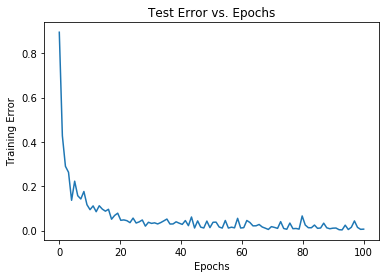

In [65]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

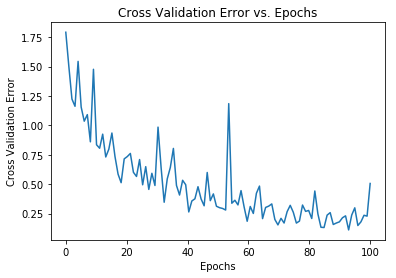

In [66]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [67]:
probability = tf.nn.softmax(model.L8)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTraining), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTrainingLabel in cnnTrainingLabels:
    if (np.argmax(cnnTrainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTrainingLabel)] += 1
    count += 1

print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The cnn neural network is 93.32291666666667% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 98.54166667  96.875       94.0625      91.14583333  94.6875      96.97916667
  92.29166667  93.95833333  96.04166667  78.64583333]


In [68]:
probability = tf.nn.softmax(model.L8)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTest), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTestLabel in cnnTestLabels:
    if (np.argmax(cnnTestLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTestLabel)] += 1
    count += 1
    
print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The cnn neural network is 80.66666666666666% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 90.41666667  84.16666667  84.58333333  74.16666667  77.08333333
  88.33333333  85.          82.08333333  88.75        52.08333333]
